# Quora Question Pairs _ simple XGB

- 두 문장간 중복되는 단어의 비중을 변수화, xgboost 모형으로 적합해봅니다. anokas의 [해당 커널](https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb) 을 주로 참조했습니다. <br>
   

### 1. loading packages, import data

필요한 패키지들을 로딩합니다.

In [1]:
import pandas as pd
import numpy as np

import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

seaborn의 color 팔레트를 지정해줍니다.

In [2]:
pal = sns.color_palette()

데이터를 불러옵니다..

In [4]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

맨 위 10줄만 뽑아봅니다. <br>
질문 아이디와 각각의 질문 내용, 그리고 두 질문이 duplicate인지 여부를 나타나는 target 컬럼으로 구성되어 있습니다.

In [5]:
train.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


### 2. EDA

**문장 길이 분포를 확인**

In [5]:
# Question Text만 List로 만들기
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
test_qs = pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)

In [6]:
# 글자수 정보 만들기
dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)

Text(0,0.5,'Probability')

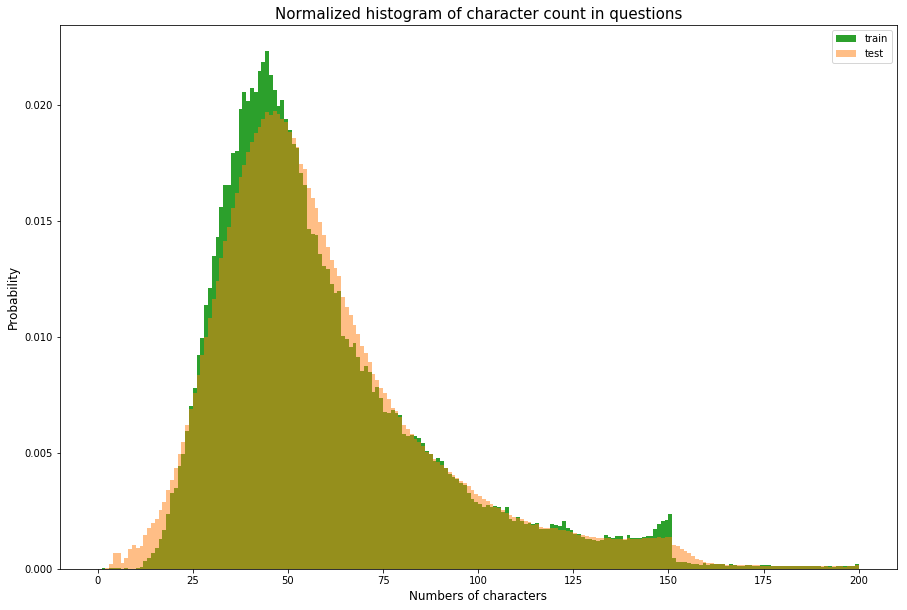

In [7]:
# train과 test의 글자수 분포 확인하기

plt.figure(figsize=(15,10))

plt.hist(dist_train, bins=200, range=[0,200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0,200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalized histogram of character count in questions', fontsize=15)

plt.legend()
plt.xlabel('Numbers of characters', fontsize=12)
plt.ylabel('Probability', fontsize=12)

거의 유사한 수준으로 분포하고 있습니다. train 데이터의 경우 150자 구간에서 급격히 감소하고 있다는 점이 눈에 띕니다. test 데이터에서는 해당 현상이 발견되지 않습니다. test 데이터는 검색을 통해서 답을 발견하는 것을 방지하기 위해 주최측에서 만든 것인데, 이것이 train과 test의 차이를 유발한 것으로 보입니다.

**단어 개수 분포 확인**

In [8]:
dist_train = train_qs.apply(lambda x:len(x.split(' ')))
dist_test = test_qs.apply(lambda x:len(x.split(' ')))

Text(0,0.5,'Probability')

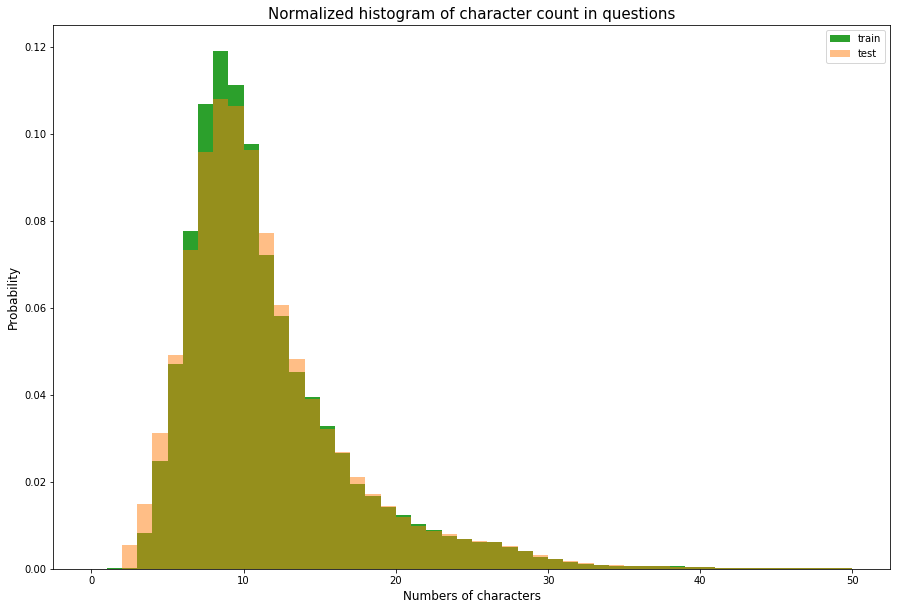

In [9]:
# train과 test의 단어수 분포 확인하기

plt.figure(figsize=(15,10))

plt.hist(dist_train, bins=50, range=[0,50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0,50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalized histogram of character count in questions', fontsize=15)

plt.legend()
plt.xlabel('Numbers of characters', fontsize=12)
plt.ylabel('Probability', fontsize=12)

눈에 띄는 큰 차이는 없습니다. train, test 모두 5 ~ 15개 사이의 단어에 분포가 몰려 있습니다.

**단어의 분포를 wordcloud로 시각화**

In [10]:
from wordcloud import WordCloud

(-0.5, 1439.5, 1079.5, -0.5)

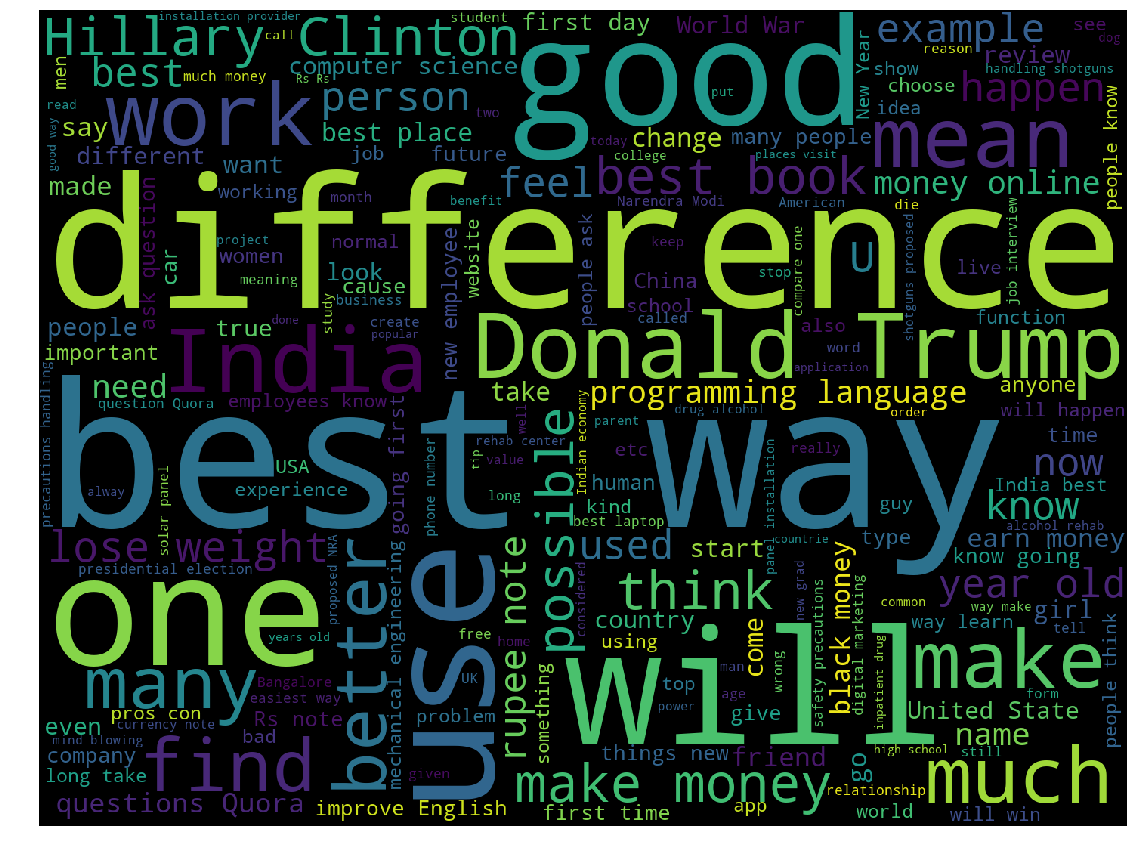

In [11]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))

plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

...그렇군요. 사실 wordcloud는 주요한 implication을 주는 경우가 많이 없습니다.

** 중복되는 단어 비중을 구하여 변수화해보기** <br>

큰 의미 없는 단어들 (stopwords)를 제거한 후, 두 문장이 공통으로 공유하는 어휘의 비중을 구해봅니다.

In [12]:
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

In [15]:
# 전체 단어 개수 중 몇 개의 단어를 공통으로 공유하고 있는지 비율 구하는 함수

def word_match_share(row):
    
    # 두 문장의 어휘 정보를 담을 딕셔너리를 만듭니다.
    q1words = {}
    q2words = {}
    
    # 각 문장의 어휘를 공백 기준으로 자른 후, 해당 어휘가 stopword에 해당하지 않으면 딕셔너리에 추가합니다.
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
            
    # 만약 두 딕셔너리 중 한 딕셔너리라도 길이가 0 이라면 0을 반환합니다.
    if len(q1words) == 0 or len(q2words)==0:
        return 0
    
    # q1과 q2가 각각 q2, q1과 중복된 어휘를 list에 추가합니다.
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    
    # 중복 어휘의 비중을 구합니다.
    r = (len(shared_words_in_q1) + len(shared_words_in_q2)) / (len(q1words) + len(q2words))
    
    return r

Text(0.5,0,'word_match_share')

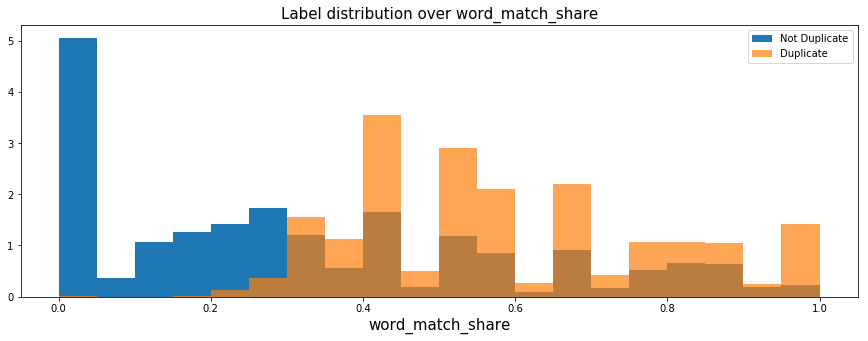

In [16]:
# 실제 함수를 적용, row별 비율 구한 후 시각화

plt.figure(figsize = (15,5))

# 위에서 만든 함수를 row마다 적용하여 값을 구합니다. 
train_word_match = train.apply(word_match_share, axis=1, raw=True)

# target이 0인 경우와 그렇지 않은 경우의 histogram을 그립니다.
plt.hist(train_word_match[train['is_duplicate']==0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[train['is_duplicate']==1], bins=20, normed=True, alpha=0.7, label='Duplicate')

plt.legend()
plt.title("Label distribution over word_match_share", fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

duplicated된 경우, 중복 비중이 더 높은 것으로 보입니다. 

** 중복되는 단어 비중을 구하여 변수화해보기 (TF-IDF 활용)** <br>

위와 동일한 방식이지만, 단순 count 방식 대신 각 어휘의 TF-IDF값을 구하여 수행해봅니다.

In [17]:
from collections import Counter

In [18]:
# idf를 구하기 위한 function

def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1/(count+eps)

In [19]:
# 위 function을 활용, 단어별 idf 값을 weights 딕셔너리에 안에 포함시킵니다.

eps = 5000

words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word : get_weight(count) for word, count in counts.items()}

In [20]:
# 위의 function과 유사하지만 단어 자체를 더해주는 대신 weight를 더해줍니다.
# 한 문장에 동일 문장이 복수로 들어가면 해당 개수만큼 weight가 더해지므로, tf * idf와 동일한 결과입니다.

def tfidf_word_match_share(row):
    
    q1words = {}
    q2words = {}
    
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
            
    if len(q1words) == 0 or len(q2words)==0:
        return 0
    
    shared_weights = [weights.get(w,0) for w in q1words.keys() if w in q2words] + [weights.get(w,0) for w in q2words.keys() if w in q1words] 
    total_weights = [weights.get(w,0) for w in q1words] + [weights.get(w,0) for w in q2words] 

    r = np.sum(shared_weights) / np.sum(total_weights)
    
    return r

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5,0,'word_match_share')

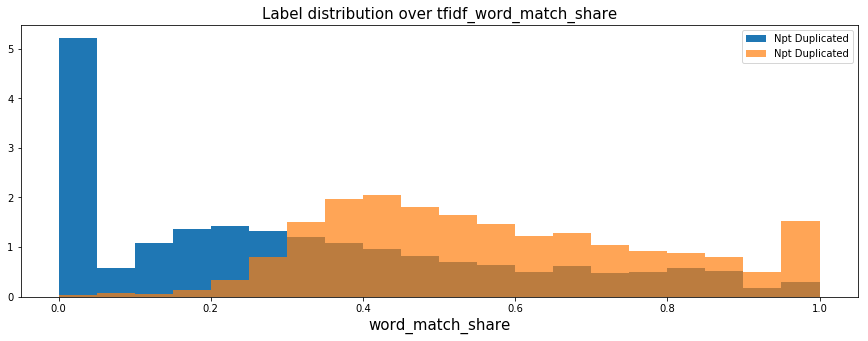

In [21]:
plt.figure(figsize=(15,5))

tfidf_train_word_match = train.apply(tfidf_word_match_share, axis=1, raw=True)

plt.hist(tfidf_train_word_match[train['is_duplicate']==0].fillna(0), bins=20, normed=True, label='Npt Duplicated')
plt.hist(tfidf_train_word_match[train['is_duplicate']==1].fillna(0), bins=20, normed=True, alpha=0.7, label='Npt Duplicated')

plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

그냥 빈도수 기반으로 했을때보다 더 잘 구분해주는 것으로 보입니다.

### 3. Running Model_xgboost 
위 두개 변수로 xgboost 모형을 실행해봅니다.

In [22]:
import xgboost as xgb

In [92]:
# 위에 만든 두 개의 변수로 dataframe 만들기
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [93]:
df_train['word_match'] = train_word_match
df_train['tfidf_word_match'] = tfidf_train_word_match

In [35]:
# test셋도 동일하게 만들어주기

df_test['word_match'] =  test.apply(word_match_share, axis=1, raw=True)
df_test['tfidf_word_match'] = test.apply(tfidf_word_match_share, axis=1, raw=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


In [94]:
# target만 별도로 만들기

df_y_train = train['is_duplicate'].values

#### 비율 조절하기

- 비율 맞춰야 하는 이유 : 지표가 AUROC라면 무방하지만, logloss라면 train과 test의 평균 타겟률 차이에 따라 지표에 차이가 발생
- 전체를 평균 반응률로 submission 했을때 나타나는 logloss 결과를 토대로 test셋의 타겟율 추정
- 결과적으로 약 17% 인 것으로 나타남. [해당 커널](https://www.kaggle.com/davidthaler/how-many-1-s-are-in-the-public-lb) 참조

In [95]:
train[train.is_duplicate==1].shape[0], train[train.is_duplicate==0].shape[0] 

(149263, 255027)

In [96]:
# 0 인 샘플이 이 갯수만큼 필요함..
int(149263 * (83/17))

728754

In [97]:
df_train_pos = df_train[df_y_train==1]
df_train_neg = df_train[df_y_train==0]

In [98]:
# 0인 샘플 한번 추가
df_train_neg = pd.concat([df_train_neg, df_train_neg], axis=0)

In [99]:
df_train_neg.shape

(510054, 2)

In [100]:
# 아직 필요한 개수 대비 21만개 부족...추가
df_train_neg = pd.concat([df_train_neg, df_train_neg.iloc[:210000,:]], axis=0)

In [101]:
# 이제 됐다...!
df_train_neg.shape

(720054, 2)

In [102]:
df_train = pd.concat([df_train_pos, df_train_neg])
df_y_train= (np.zeros(len(df_train_pos)) + 1).tolist() + np.zeros(len(df_train_neg)).tolist()

In [103]:
np.mean(df_y_train)

0.17170146218237997

** 이제 모형 만들기 **

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df_train, df_y_train, test_size=0.2, random_state=4242)

In [106]:
# 파라미터 세팅

params = {}

params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.01
params['max_depth'] = 8

In [107]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)

In [108]:
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

In [109]:
bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=100, verbose_eval=200)

[0]	train-logloss:0.687782	valid-logloss:0.687779
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[200]	train-logloss:0.368505	valid-logloss:0.368541
[400]	train-logloss:0.342509	valid-logloss:0.342924
[600]	train-logloss:0.338998	valid-logloss:0.339902
[800]	train-logloss:0.337635	valid-logloss:0.339055
[999]	train-logloss:0.33682	valid-logloss:0.338648


In [110]:
# logloss .35218

d_test = xgb.DMatrix(df_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('../submission/simple_xgb_v2.1.csv', index=False)